# `photoeccentric` Tutorial (Only Transit Fit)

Full tutorial at https://github.com/ssagear/photoeccentric/blob/master/notebooks/photoeccentric_tutorial.ipynb

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

In [2]:
nwalk = 64
nsteps = 3000
ndiscard = 1000
arrlen = (nsteps-ndiscard)*nwalk

I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [3]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

In [4]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")


I'm reading in a file containing data for all Kepler planets from the Exoplanet Archive (`planets`), then only taking these data for planets in the Muirhead et al. 2013 sample (`spectplanets`).

In [5]:
# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

Now, I'm reading in the entire Kepler/Gaia dataset from [gaia-kepler.fun]. I'm again matching these data with the objects in our sample (`muirhead_gaia`). I'm using the DR2 data with a 4 arcsecond search radius.

Then I'll combine the spectroscopy data with Kepler/Gaia data for our sample.

In [7]:
# Kepler-Gaia Data

# This file is too big to upload to github -- download from https://gaia-kepler.fun (4" search radius)
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Defining a "test planet"

I'm going to pick a random planet from our sample to test how well `photoeccentric` works. Here, I'm picking Kepler-1582 b, a super-Earth orbiting an M dwarf [Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/2457/kepler-1582-b/). It has an orbital period of about 5 days.

First, I'll use the spectroscopy data from Muirhead et al. 2013 and Gaia luminosities to constrain the mass and radius of the host star beyond the constraint published in the Exoplanet Archive. I'll do this by matching these data with stellar isochrones [MESA](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/102) (check this ciation) and using the masses/radii from the matching isochrones to constrian the stellar density.

In [8]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]


In [9]:
# Read in MESA isochrones
# File is not in Github repo
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')


##### Using `ph.fit_isochrone_lum()` to match isochrones to stellar data

In [10]:
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

100%|██████████| 738479/738479 [00:56<00:00, 13011.85it/s]


In [11]:
# Write to csv, then read back in (prevents python notebook from lagging)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [12]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

I'm determining the mass and radius constraints of this star based on the isochrones that were consistent with the observational data.

In [13]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

##### Using `ph.find_density_dist_symmetric()` to create a stellar density distribution from symmetric (Gaussian) distributions based on mstar and rstar (from isochrones). 
Note: this does not necessarily mean the resulting density distribution will appear symmetric.

In [14]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

Text(0.5, 0, 'Stellar Density Histogram (kg m^-3)')

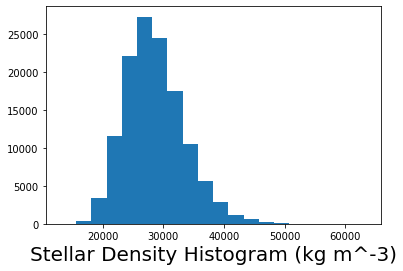

In [15]:
plt.hist(rho_star, bins=20)
plt.xlabel('Stellar Density Histogram (kg m^-3)', fontsize=20)

# Creating a fake light curve based on a real planet

I'm pulling the planet parameters of Kepler-1582 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, Rp/Rs, and inclination constraints of this planet. (It will also return some other parameters, but we don't need those right now).

#### I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.

In [16]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints I determined

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## $e = 0.0$, $\omega = 90.0$

In [17]:
time = np.linspace(-24, 24, 10000)

In [18]:
def planetlc(time, per, rp, a, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.1, 0.3]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [19]:
# Calculate flux from transit model
w = 90.0
flux = planetlc(time, period, rprs, a_rs, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00005,len(time))
nflux = flux+noise
flux_err = np.array([0.00005]*len(nflux))

Text(0, 0.5, 'Flux')

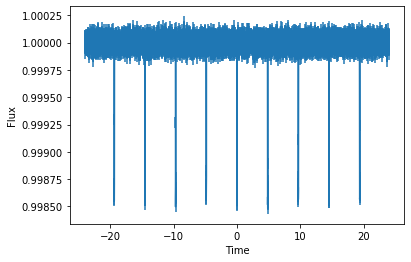

In [20]:
plt.errorbar(time, nflux, yerr=flux_err)
plt.xlabel('Time')
plt.ylabel('Flux')
#plt.xlim(-1, 1)

## Fitting the transit

I'm using the Astropy BLS method to determine the period of the fake light curve, and use this as the period "guess" (`per_guess`).

In [21]:
per_guess = ph.bls(time, nflux)

Now, I'm fitting the transit shape with scipy.curve_fit. $p$, $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e != 0, the transit fitter will fit the wrong values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values pretty close to what I input.

In [22]:
print('Period fit: ', per_guess)

Period fit:  4.848484848484853


In [23]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 35, 89]

dr = 'e_' + str(0) + '_w_' + str(w)
direct = '/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
res, errs, pdist, rdist, adist, idist = ph.mcmc_fitter(p0, time, nflux, flux_err, nwalk, nsteps, ndiscard, e, w, direct)

p_f, rprs_f, a_f, i_f = res
perr_f, rprserr_f, aerr_f, ierr_f = errs

# Create a light curve with the fit parameters
fit = ph.planetlc_fitter(time, p_f, rprs_f, a_f, i_f, 0.0)


NameError: name 'e' is not defined

Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

In [ ]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Period (days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('w (deg): ', w)

print('\n')

print('Fit params:')
print('Period (days): ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)